# Project 5, Partial Differential Equations cont'd
**Devon DeJohn** | PHY 4611 | April 22, 2019

> This project explores the Forward Time Centered Space method for solving the heat/diffusion equation in a 1D rod. The bare-bones FTCS method is said to be "conditionally stable", depending on the time step chosen. We modify `FTCS` to accept Neumann boundary conditions (where the flux is given) and periodic boundary conditions (where the temperature and flux are equal at both ends of the bar). Finally we briefly explore the DuFort-Frankel method, which is unconditionally stable for all timestep values.

## 6.1 PDE Solution Check

> Show that 
>
> $$T_G(x,t) = \frac{1}{\sigma (t) \sqrt{2\pi}} exp \bigg{[} \frac{-(x - x_0)^2}{2 \sigma ^2(t)} \bigg{]}$$
>
> is a solution to the diffusion PDE. Where $\sigma(t) = \sqrt{2 \kappa t}$.

See attached for answer.

## 6.3 Dirichlet Forward Time Centered Space

> Run the `dftcs` program with $N=61$ and a variety of values for $\tau$ between $10^{-5}$ and $10^{-3}$. For $\tau=1.0\times 10^{-4}$, try a variety of values for $N$. What do you observe?

In my implementation, `FTCS` becomes unstable for $\tau > 1.35\times 10^{-4}$. Unfortunately I can't even run the alogrithm past that as the program crashes. The crashing seems to have more to do with the contour map plotting however, which I believe is bugged right now (as contour level labels aren't showing either). I am also unable to plot for $N=100$ and above with the timestep fixed at $1.0\times 10^{-4}$.

In [14]:
using Plots
gr()

const L = 1. # System size
const c = 1. # wave speed

# t = timestep, n = number of grid points, mthd = integration method, tt = total time,
# pbc = periodic BCs (true/false), fq = frequency (for Dirichlet).
function advect(t, n, tt=1.0; mthd, pbc, fq)
    # Grid spacing.
    h = L/n

    k = c*t/(2*h) # Coefficient for all schemes.
    klw = 2*k^2 # Coefficient for Lax-Wendroff.

    # Initial conditions; integrate to total time.
    steps = Int(round(tt/t))
    
    sig = 0.1 # Width of Gaussian pulse.
    wn = pi/sig # Wave number.

    # x- and time-values for plotting.
    xvals = [h*i - L/2 for i in 0:(n-1)]
    tvals = [t*i for i in 0:(steps-1)]
    
    wv = zeros(steps, n)
    
    # Initial wave pulse if periodic BCs selected.
    if pbc 
        for (i,x) in enumerate(xvals)
            wv[1,i] = exp(-x^2/(2*sig^2)) * cos(wn*x)
        end
    end

    return (mthd(wv, n, steps, k, pbc, fq, t, klw), xvals, tvals, n, t)
end

function ftcs(x...)
    wv, n, steps, k, pbc, fq, t = x

    for i in 2:steps
        if pbc
            # Periodic BCs
            for j in 1:n
                lft, rt = mod(j-2,n)+1, mod(j,n)+1
                wv[i,j] = wv[i-1,j] - k*(wv[i-1,lft] - wv[i-1,rt])
            end
        else
            # Dirichlet BCs
            wv[i,1] = sin(t*i*fq)
            for j in 2:(n-1)
                wv[i,j] = wv[i-1,j] - k*(wv[i-1,j-1] - wv[i-1,j+1])
            end
            wv[1,n] = 0
        end
    end
    
    return wv
end

function lax(x...)
    wv, n, steps, k, pbc, fq, t = x

    for i in 2:steps
        if pbc
            # Periodic BCs
            for j in 1:n
                lft, rt = mod(j-2,n)+1, mod(j,n)+1
                wv[i,j] = 0.5*(wv[i-1,rt] + wv[i-1,lft]) - k*(wv[i-1,rt] - wv[i-1,lft])
            end
        else
            # Dirichlet BCs
            wv[i,1] = sin(t*i*fq)
            for j in 2:(n-1)
                wv[i,j] = 0.5*(wv[i-1,j+1] + wv[i-1,j-1]) - k*(wv[i-1,j+1] - wv[i-1,j-1])
            end
            wv[1,n] = 0
        end
    end
    
    return wv
end

function wdf(x...)
    wv, n, steps, k, pbc, fq, t, klw = x

    for i in 2:steps
        if pbc
            # Periodic BCs
            for j in 1:n
                lft, rt = mod(j-2,n)+1, mod(j,n)+1
                wv[2,j] = wv[1,j] - k*(wv[1,rt] - wv[1,lft]) + klw*(wv[1,rt] + wv[1,lft] - 2*wv[1,j])
            end
        else
            # Dirichlet BCs
            wv[i,1] = sin(t*i*fq)
            for j in 2:(n-1)
                wv[i,j] = wv[i-1,j] - k*(wv[i-1,j+1] - wv[i-1,j-1]) + klw*(wv[i-1,j+1] + wv[i-1,j-1] - 2*wv[i-1,j])
            end
            wv[i,n] = 0
        end
    end
    
    return wv
end

function upwind(x...)
    wv, n, steps, k, pbc, fq, t, klw = x
    
    for i in 2:steps
        if pbc
            # Periodic BCs
            for j in 1:n
                wv[i,j] = wv[i-1,j] - 2*k*(wv[i-1,j] - wv[i-1,mod(j-2,n)+1])
            end
        else
            # Dirichlet BCs
            wv[i,1] = sin(t*i*fq)
            for j in 2:(n-1)
                wv[i,j] = wv[i-1,j] - 2*k*(wv[i-1,j] - wv[i-1,j-1])
            end
            wv[i,n] = 0
        end
    end
    
    return wv
end

function leapfrog(x...)
    wv, n, steps, k, pbc, fq, t, klw = x
    
    # One iteration of Lax-Wendroff to get leapfrog started.
    for j in 1:n
        lft, rt = mod(j-2,n)+1, mod(j,n)+1
        wv[2,j] = wv[1,j] - k*(wv[1,rt] - wv[1,lft]) + klw*(wv[1,rt] + wv[1,lft] - 2*wv[1,j])
    end
    
    for i in 3:steps
        if pbc
            # Periodic BCs
            for j in 1:n
                lft, rt = mod(j-2,n)+1, mod(j,n)+1
                wv[i,j] = wv[i-2,j] - 2*k*(wv[i-1,rt] - wv[i-1,lft])
            end
        else
            # Dirichlet BCs
            wv[i,1] = sin(t*i*fq)
            for j in 2:(n-1)
                wv[i,j] = wv[i-2,j] - 2*k*(wv[i-1,j+1] - wv[i-1,j-1])
            end
            wv[i,n] = 0
        end
    end
    
    return wv
end

function plt_dat(dat)
    wv, x, t, nstep, tstep = dat
    ttl = string("Advection for dt = ", string(tstep), " s, N = ", string(nstep))
    p1=surface(x, t, wv, title=ttl,
            xlabel=:"x", ylabel=:"time", zlabel=:"a(x,t)", 
            color=:Spectral_r, colorbar=false,
            st=:surface, camera=(25,50))
    p2=plot(x, wv[1,:], label="Initial")
    plot!(p2, x, wv[end,:], label="Final")
    plot(p1, p2, layout=2, size=(950,450))
end;

In [ ]:
plt_dat(advect(0.002, 50, mthd=ftcs))

In [ ]:
plt_dat(advect(0.02, 50, mthd=lax))

In [ ]:
plt_dat(advect(0.02, 50, mthd=wdf))

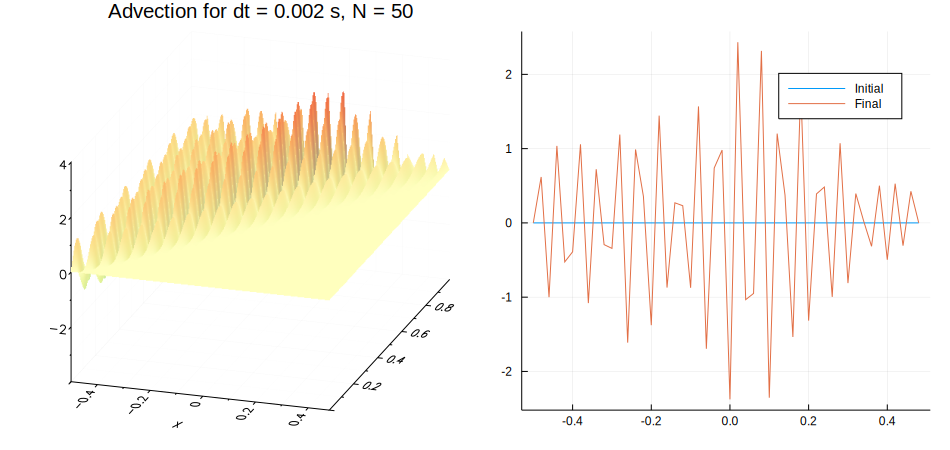

In [4]:
plt_dat(advect(0.002, 50, mthd=ftcs, pbc=false, fq=10*pi))

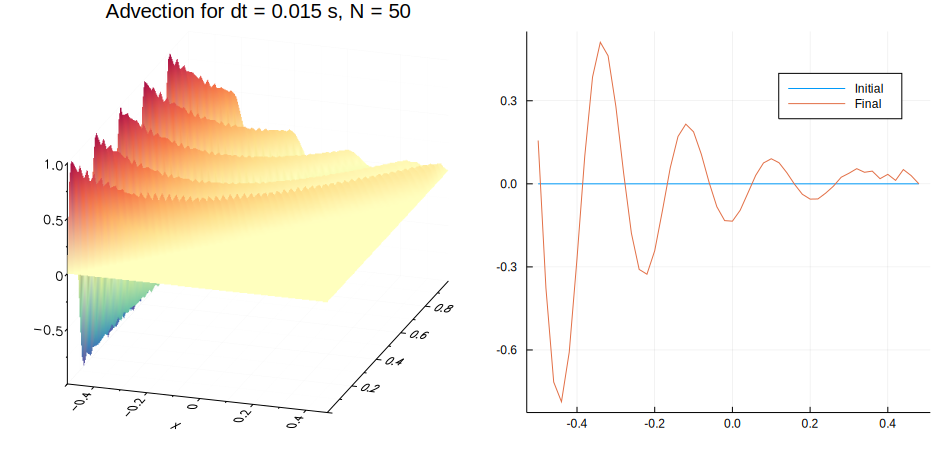

In [6]:
plt_dat(advect(0.015, 50, mthd=lax, pbc=false, fq=10*pi))

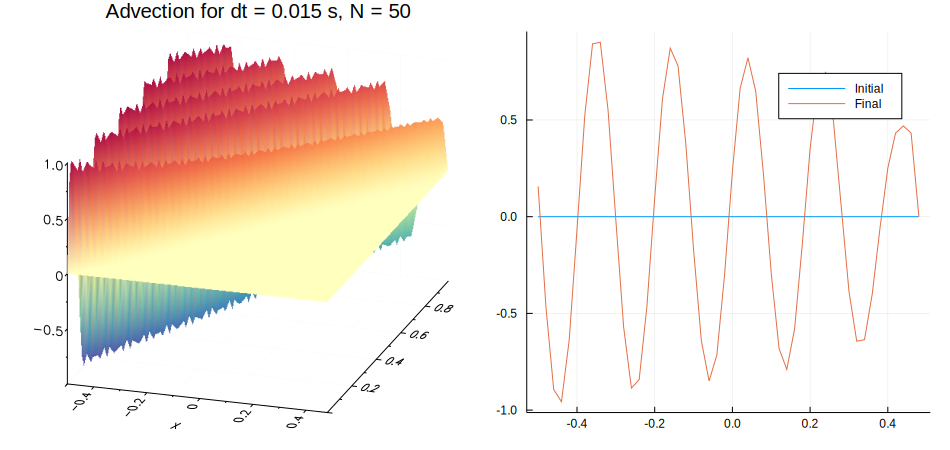

In [5]:
plt_dat(advect(0.015, 50, mthd=wdf, pbc=false, fq=10*pi))

In [12]:
function dir_gif(dat)
    wv, x, t, nstep, tstep = dat
    
    max_amp = 1.25
    min_amp = -1.25
    max_x = maximum(x)
    min_x = minimum(x)

    anim = @animate for i=1:2:Int(round(size(wv,1)))
        dt = "$(round(t[i], digits=4))"
        if length(dt) < 6
            dt = rpad(dt, 6, "0")
        end
        ttl = string("Sinusoidal dirichlet BC at time t = ", dt, " s")
        plot(size=(900,500), xlabel=:"x", ylabel=:"a(x)", xlims=(min_x, max_x), ylims=(min_amp, max_amp), title=ttl)
        plot!(x, wv[i, :], lw=4, label=:"")
    end every 5
    gif(anim, "advect.gif")
end;

In [15]:
dir_gif(advect(0.002, 100, 2., mthd=wdf, pbc=false, fq=10*pi))

┌ Info: Saved animation to 
│   fn = C:\Users\Devon\Dropbox\programming\jupyter\PHY 4611\advect.gif
└ @ Plots C:\Users\Devon\.julia\dev\Plots\src\animation.jl:90


Plots.AnimatedGif("C:\\Users\\Devon\\Dropbox\\programming\\jupyter\\PHY 4611\\advect.gif")